# Labs

## 0. Load libraries

### WARNING!

Install local robin module: `python3 -m pip install -e /Users/david/PycharmProjects/robin`

In [14]:
%load_ext autoreload
%autoreload 2

import cProfile as profile
import numpy as np
import pandas as pd
import time

from benchmarks.generator import get_revenue_behaviour
from benchmarks.robin_railway import RevenueMaximization
from benchmarks.utils import sns_box_plot, sns_line_plot, int_input, get_schedule_from_supply, TrainSchedulePlotter, infer_line_stations, get_services_by_tsp_df
from src.entities import GSA, Solution

from robin.kernel.entities import Kernel
from robin.plotter.entities import KernelPlotter
from robin.scraping.entities import SupplySaver
from robin.services_generator.entities import ServiceGenerator
from robin.supply.entities import Service, Supply

from pathlib import Path
from tqdm.notebook import tqdm
from typing import Any, List, Mapping, Tuple, Union
import shutil

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
# Config files
supply_config_path = Path("../configs/generator/supply_config.yml")
demand_config_path = Path("../configs/demand/demand.yml")
generator_config_path = Path("../configs/generator/generator_config.yml")

# Save paths
generator_save_path = Path(f'../data/generator/supply_dummy.yml')
supply_save_path = '../configs/gsa_results/'
robin_save_path = '../data/output/robin/'
figures = '../figures/'

# Clean save paths directories
if Path(generator_save_path.parent).exists():
    shutil.rmtree(generator_save_path.parent)

Path(generator_save_path.parent).mkdir(parents=True)

if Path(supply_save_path).exists():
    shutil.rmtree(supply_save_path)
    
Path(supply_save_path).mkdir(parents=True)

if Path(robin_save_path).exists():
    shutil.rmtree(robin_save_path)
    
Path(robin_save_path).mkdir(parents=True)

if Path(figures).exists():
    shutil.rmtree(figures)

Path(figures).mkdir(parents=True)

In [16]:
seed = 21

if generator_config_path:
    n_services = int_input("Number of services to generate: ")
    generator = ServiceGenerator(supply_config_path=supply_config_path)
    _ = generator.generate(file_name=generator_save_path,
                           path_config=generator_config_path,
                           n_services=n_services,
                           seed=seed)
    print(f'Number of service requests generated: {len(_)}')

Number of service requests generated: 20


In [17]:
supply = Supply.from_yaml(generator_save_path)
tsp_df = get_services_by_tsp_df(supply.services)

print(tsp_df)

       Number of Services
AVLO                    4
IRYO                    8
AVE                     5
OUIGO                   3
Total                  20


Services:  20


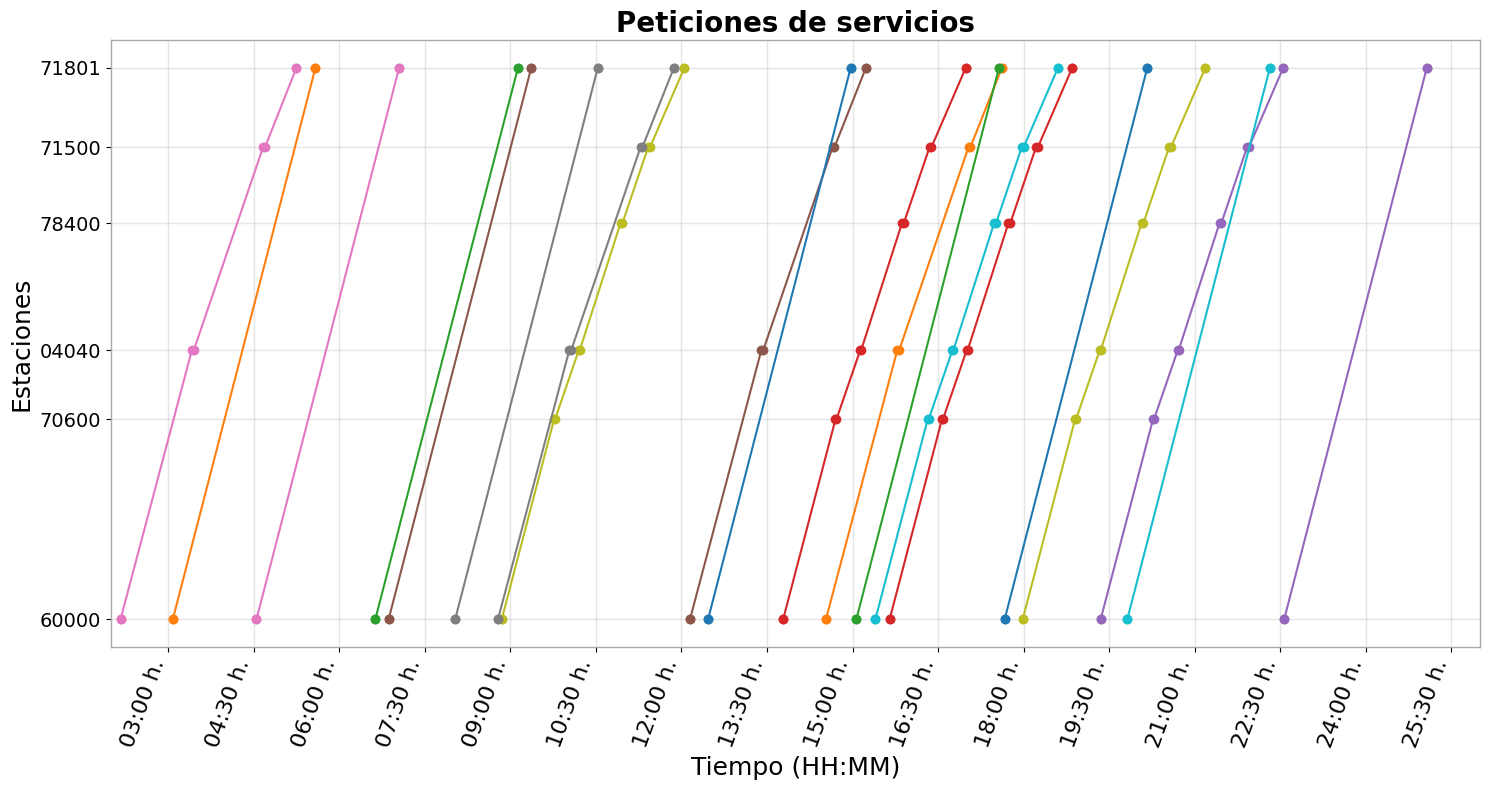

In [18]:
print("Services: ", len(supply.services))
requested_schedule = get_schedule_from_supply(generator_save_path)
revenue_behaviour = get_revenue_behaviour(requested_schedule)
lines = supply.lines
line = infer_line_stations(lines)

plotter = TrainSchedulePlotter(requested_schedule, line)
plotter.plot(main_title="Peticiones de servicios")

In [19]:
#pr = profile.Profile()
#pr.enable()

def run_gsa(chaotic_constant: bool=False,
            runs: int=10,
            population_size: int=20,
            iters: int=50
            ) -> Tuple[pd.DataFrame, pd.DataFrame, Any]:
    runs_best_solution_history = {}
    
    global_train_hist = pd.DataFrame()
    global_population_hist = pd.DataFrame()
    
    for r in tqdm(range(1, runs + 1)):
        sm = RevenueMaximization(requested_schedule=requested_schedule,
                                 revenue_behaviour=revenue_behaviour,
                                 line=line,
                                 safe_headway=10)
    
        gsa_algo = GSA(objective_function=sm.get_fitness_gsa,
                       is_feasible=sm.feasible_services_times,
                       custom_repair=sm.custom_repair,
                       r_dim=len(sm.boundaries.real),
                       d_dim=0,
                       boundaries=sm.boundaries)
    
        training_history = gsa_algo.optimize(population_size=population_size,
                                             iters=iters,
                                             chaotic_constant=chaotic_constant,
                                             repair_solution=True,
                                             initial_population=sm.get_initial_population(population),
                                             verbose=verbosity,
                                             save_population=True)
    
        training_history.insert(0, "Run", r)
        training_history['Discrete'] = [sm.get_heuristic_schedule(Solution(real=r, discrete=np.array([]))) for r in training_history['Real']]
        global_train_hist = pd.concat([global_train_hist, training_history], axis=0)
        
        gsa_algo.population_history.insert(0, "Run", r)
        global_population_hist = pd.concat([global_population_hist, gsa_algo.population_history], axis=0)
    
        runs_best_solution_history[r] = (sm.best_solution, sm.best_revenue)
        
    return global_train_hist, global_population_hist, runs_best_solution_history
        
#pr.disable()
#pr.dump_stats('profile.pstat')

In [20]:
runs = 5
population = 20
iters = 50
chaotic = True
verbosity = False

df_train_global, df_population, runs_best_solution_history = run_gsa(chaotic_constant=chaotic,
                                                                     runs=runs,
                                                                     population_size=population,
                                                                     iters=iters)

  0%|          | 0/5 [00:00<?, ?it/s]

## 1. Chaotic vs Normal GSA

In [63]:
runs = 5
population = 20
iters = 50

df_gcc = pd.DataFrame()
df_gpp = pd.DataFrame()
for chaotic_constant in [True, False]:
    print(f"Running GSA with chaotic constant: ", chaotic_constant)
    df_train, df_pop = run_gsa(chaotic_constant=chaotic_constant,
                               runs=runs,
                               population_size=population,
                               iters=iters)
    
    df_train["chaotic_constant"] = chaotic_constant
    df_gcc = pd.concat([df_gcc, df_train], axis=0)
    
    df_pop["chaotic_constant"] = chaotic_constant
    df_gpp = pd.concat([df_gpp, df_pop], axis=0)

Running GSA with chaotic constant:  True


  0%|          | 0/5 [00:00<?, ?it/s]

Running GSA with chaotic constant:  False


  0%|          | 0/5 [00:00<?, ?it/s]

In [68]:
df_pop = df_gpp.copy()

df_pop.drop(columns=[col for col in df_pop.columns if 'discrete' in col], inplace=True)

def fitness_from_real(x: np.array) -> float:
    solution_gsa = Solution(real=x, discrete=np.array([]))
    fitness, _ = sm.get_fitness_gsa(timetable=solution_gsa)
    return fitness

df_pop.loc[:, df_pop.columns.str.contains('real_')] = df_pop.loc[:, df_pop.columns.str.contains('real_')].map(fitness_from_real)
df_pop

,Run,Iteration,real_0,real_1,real_2,real_3,real_4,real_5,real_6,real_7,...,real_11,real_12,real_13,real_14,real_15,real_16,real_17,real_18,real_19,chaotic_constant
0,1,0,2921.977241,2843.245655,2799.116771,2847.013953,2914.482453,2846.569755,2866.137586,2911.7346,...,2893.355023,2886.338701,2883.480192,2897.4176,2883.774277,2946.221503,2888.743591,2890.29473,2844.752343,True
1,1,1,2815.420591,2709.298557,2862.608582,2828.888159,2909.135286,2861.158987,2753.023274,2783.198002,...,2872.680761,2820.615024,2885.867719,2823.834716,2690.688032,2777.665111,2801.620037,2917.826038,2806.75764,True
2,1,2,2890.307246,2780.811145,2882.163064,2857.950709,2885.905404,2856.336105,2846.175087,2853.683533,...,2868.856971,2876.308622,2908.567888,2914.085282,2855.115607,2803.068624,2797.57227,2894.832045,2853.798401,True
3,1,3,2872.628888,2908.118244,2873.579584,2815.576318,2877.955841,2888.737413,2882.697265,2867.850405,...,2892.314746,2846.158849,2869.240488,2923.978623,2919.296469,2882.469766,2941.314263,2891.789431,2909.676085,True
4,1,4,2901.555769,2799.458078,2889.48653,2880.794636,2899.0038,2830.417647,2839.726117,2849.335161,...,2937.883642,2901.024865,2919.442166,2873.835904,2875.96588,2937.229155,2899.356663,2886.857586,2869.072985,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45,5,45,2960.003434,2951.343728,2936.461878,2918.817935,2953.284447,2924.440472,2916.399206,2927.318362,...,2928.200653,2901.329255,2914.41951,2949.95859,2887.912251,2935.127857,2904.774162,2952.294086,2938.91614,False
46,5,46,2960.003434,2951.343728,2936.461878,2918.817935,2953.284447,2924.440472,2916.399206,2927.318362,...,2928.200653,2901.329255,2914.41951,2949.95859,2887.912251,2935.127857,2904.774162,2952.294086,2938.91614,False
47,5,47,2960.003434,2951.343728,2936.461878,2918.817935,2953.284447,2924.440472,2916.399206,2927.318362,...,2928.200653,2901.329255,2914.41951,2949.95859,2887.912251,2935.127857,2904.774162,2952.294086,2938.91614,False
48,5,48,2960.003434,2951.343728,2936.461878,2918.817935,2953.284447,2924.440472,2916.399206,2927.318362,...,2928.200653,2901.329255,2914.41951,2949.95859,2887.912251,2935.127857,2904.774162,2952.294086,2938.91614,False


In [88]:
rows = []
for row in df_pop.iterrows():
    run = row[1]['Run']
    iteration = row[1]['Iteration']
    chaotic = row[1]['chaotic_constant']
    
    for individual in [ind_name for ind_name in row[1].index if 'real_' in ind_name]:
        fitness = row[1][individual]
        rows.append({'Run': run, 'Iteration': iteration, 'Fitness': fitness, 'Chaotic': chaotic, 'Individual': f'ID_{individual}'})
        
df_boxplot = pd.DataFrame.from_dict(rows, orient='columns')
df_boxplot

,Run,Iteration,Fitness,Chaotic,Individual
0,1,0,2921.977241,True,ID_real_0
1,1,0,2843.245655,True,ID_real_1
2,1,0,2799.116771,True,ID_real_2
3,1,0,2847.013953,True,ID_real_3
4,1,0,2914.482453,True,ID_real_4
...,...,...,...,...,...
9995,5,49,2887.912251,False,ID_real_15
9996,5,49,2935.127857,False,ID_real_16
9997,5,49,2904.774162,False,ID_real_17
9998,5,49,2952.294086,False,ID_real_18


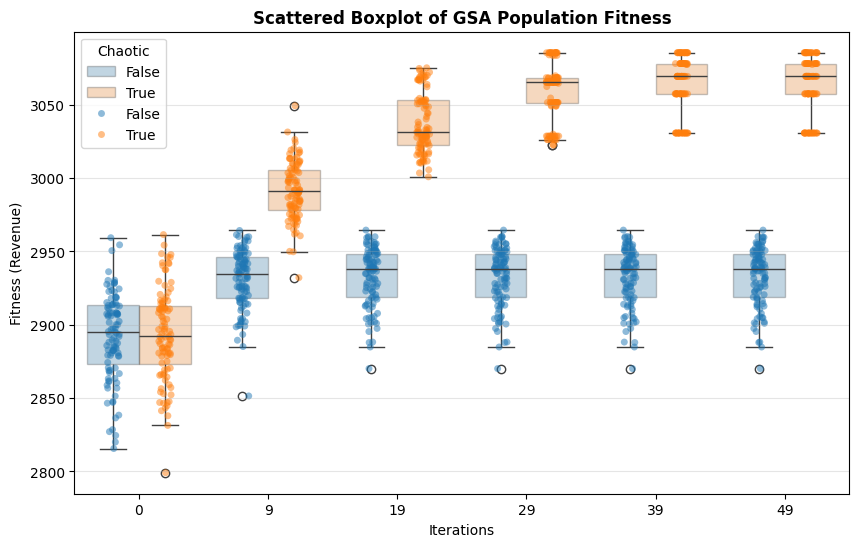

In [93]:
sns_box_plot(df=df_boxplot,
             x_data='Iteration',
             y_data='Fitness',
             hue='Chaotic',
             title="Scattered Boxplot of GSA Population Fitness",
             x_label="Iterations",
             y_label="Fitness (Revenue)",
             save_path=Path('../figures/scattered_boxplot.pdf'))

In [21]:
sm = RevenueMaximization(requested_schedule=requested_schedule,
                         revenue_behaviour=revenue_behaviour,
                         line=line,
                         safe_headway=10)

In [22]:
# Table with results by run
service_tsps = {service.id: service.tsp.name for service in supply.services}
columns = ['Run', 'Revenue', 'Execution Time (s.)', 'Scheduled Trains', 'Delta DT (min.)', 'Delta TT (min.)']
columns += set(service_tsps.values())

summary_df = pd.DataFrame(columns=columns)

run_grouped_df = df_train_global.groupby('Run')

for group in run_grouped_df.groups:
    run = run_grouped_df.get_group(group)['Run'].iloc[-1]
    revenue = run_grouped_df.get_group(group)['Fitness'].iloc[-1]
    execution_time = run_grouped_df.get_group(group)['ExecutionTime'].iloc[-1]
    scheduled_trains_array = run_grouped_df.get_group(group)['Discrete'].iloc[-1]
    scheduled_trains = int(sum(run_grouped_df.get_group(group)['Discrete'].iloc[-1]))
    real_solution = run_grouped_df.get_group(group)['Real'].iloc[-1]
    sm.update_schedule(Solution(real=real_solution, discrete=scheduled_trains))
    delta_dt = 0.0
    delta_tt = 0.0
    services_by_tsp = {tsp: 0 for tsp in service_tsps.values()}
    for i, service in enumerate(sm.requested_schedule):
        if not scheduled_trains_array[i]:
            continue
        departure_station = list(sm.requested_schedule[service].keys())[0]
        delta_dt += abs(sm.updated_schedule[service][departure_station][1] -
                        sm.requested_schedule[service][departure_station][1])
        for j, stop in enumerate(sm.requested_schedule[service].keys()):
            if j == 0 or j == len(sm.requested_schedule[service]) - 1:
                continue
            delta_tt += abs(sm.updated_schedule[service][stop][1] - sm.requested_schedule[service][stop][1])

        service_tsp = service_tsps[service]
        services_by_tsp[service_tsp] += 1

    percentages_by_tsp = {}
    for tsp in services_by_tsp:
        percentages_by_tsp[tsp] = f"{np.round(services_by_tsp[tsp] / tsp_df.loc[tsp, 'Number of Services'] * 100,2)} %"
    row_data =  [run, revenue, execution_time, scheduled_trains, delta_dt, delta_tt, *list(percentages_by_tsp.values())]
    summary_df.loc[len(summary_df)] = row_data

summary_df = summary_df.sort_values('Revenue', ascending=False)
display(summary_df)

,Run,Revenue,Execution Time (s.),Scheduled Trains,Delta DT (min.),Delta TT (min.),OUIGO,AVE,IRYO,AVLO
4,5,3158.306331,4.955350,13,5.0,60.0,50.0 %,62.5 %,60.0 %,100.0 %
2,3,3071.624363,5.003194,13,6.0,90.0,50.0 %,62.5 %,60.0 %,100.0 %
3,4,3060.062583,4.982307,13,9.0,92.0,50.0 %,62.5 %,60.0 %,100.0 %
0,1,3045.920517,4.952864,13,8.0,96.0,50.0 %,62.5 %,60.0 %,100.0 %
1,2,3035.490329,4.949831,13,4.0,119.0,50.0 %,62.5 %,60.0 %,100.0 %


In [23]:
# Global status
print("Global GSA status:")

# Execution time (mean and std.)
run_times = run_grouped_df['ExecutionTime'].last()
print(f'\tTotal execution time: {round(run_times.sum(), 4)} s.')
print(f'\tExecution Time (by run) - Mean: {round(run_times.mean(), 4)} s. - Std: {round(run_times.std(), 4)} s.')

# Revenue (mean and std.)
run_revenues = run_grouped_df['Fitness'].last()
print(f'\tRevenue - Mean: {round(run_revenues.mean(), 4)} - Std: {round(run_revenues.std(), 4)}')

# Scheduled trains (mean and std.)
run_trains = run_grouped_df['Discrete'].last().apply(sum)
print(f'\tScheduled Trains - Mean: {np.round(run_trains.mean())} - Std: {np.round(run_trains.std())}')

runs_best_solution_history = dict(sorted(runs_best_solution_history.items(),
                                         key=lambda x: x[1][1]))

q2_solution_index = np.floor(runs // 2).astype(int)
gsa_solution = tuple(runs_best_solution_history.items())[q2_solution_index]

print(f"\tMedian solution: Run {gsa_solution[0]}")
max_revenue = sum([sm.revenue[service]['canon'] for service in sm.revenue])
print(f"\tMax Revenue: {max_revenue} - WARNING!: Scheduling all services could not be feasible")

Global GSA status:
	Total execution time: 24.8435 s.
	Execution Time (by run) - Mean: 4.9687 s. - Std: 0.0232 s.
	Revenue - Mean: 3074.2808 - Std: 48.9349
	Scheduled Trains - Mean: 13.0 - Std: 0.0
	Median solution: Run 4
	Max Revenue: 4559.5 - WARNING!: Scheduling all services could not be feasible


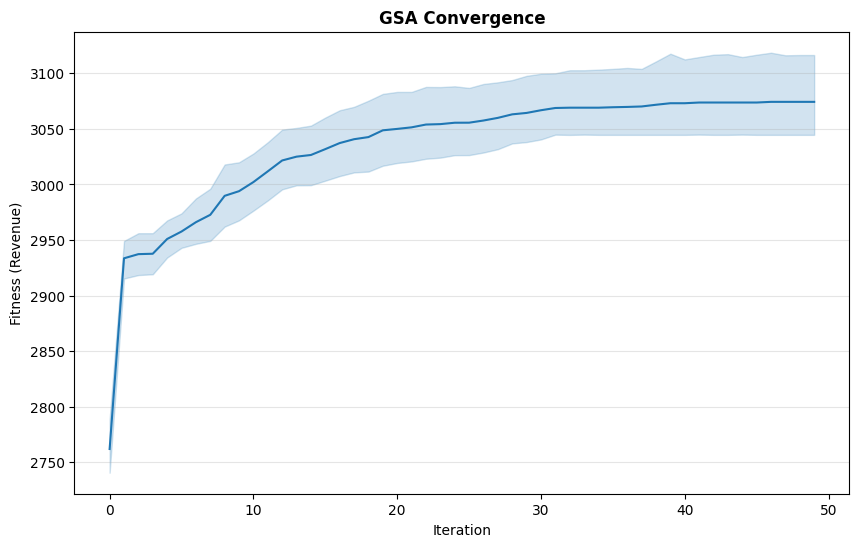

In [24]:
# GSA Convergence plot
sns_line_plot(df=df_train_global,
              x_data="Iteration",
              y_data="Fitness",
              # hue="chaotic_constant",
              title="GSA Convergence",
              x_label="Iteration",
              y_label="Fitness (Revenue)",
              save_path=Path('../figures/gsa_convergence.pdf'))

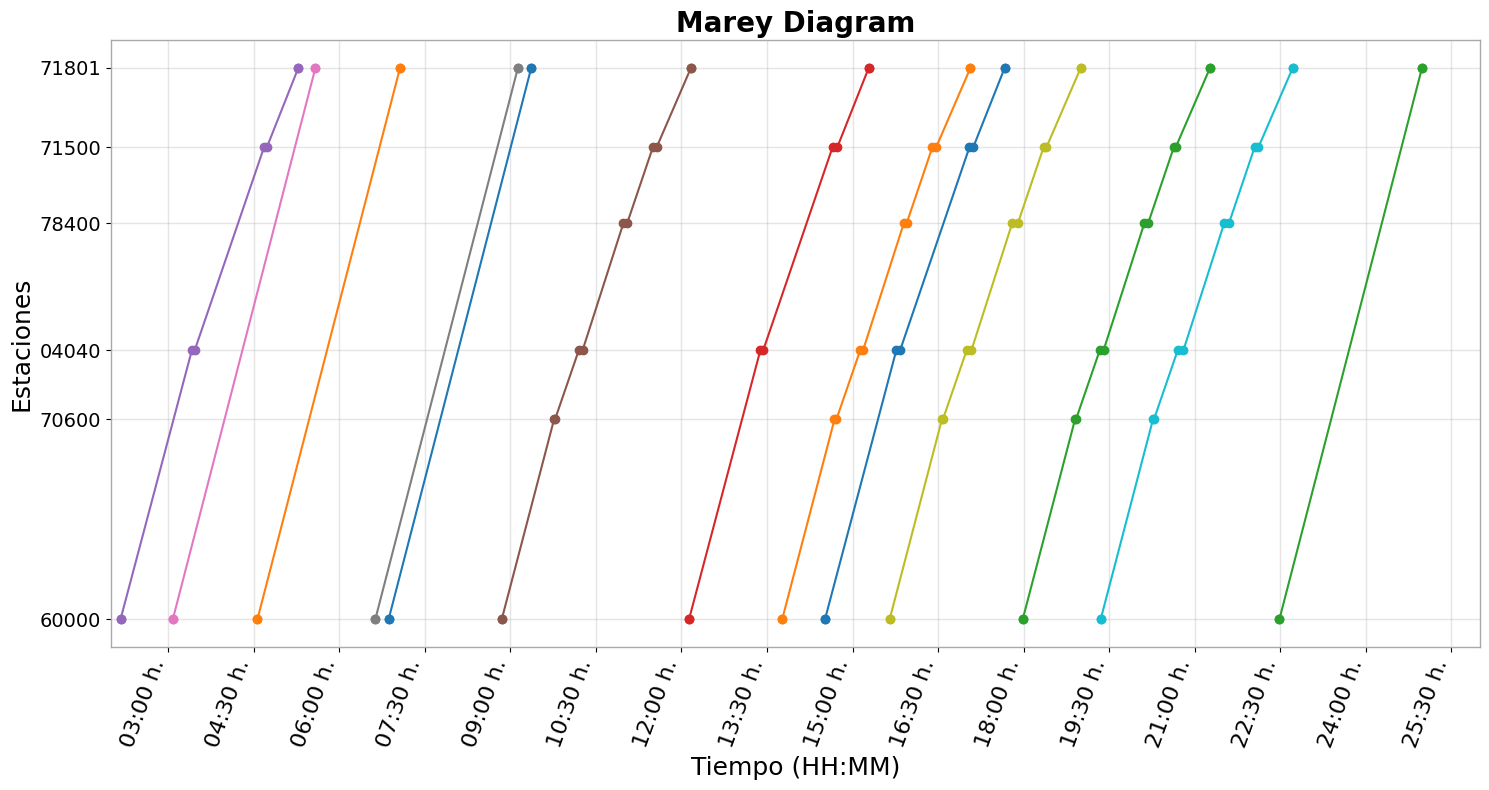

In [25]:
sm = RevenueMaximization(requested_schedule=requested_schedule,
                         revenue_behaviour=revenue_behaviour,
                         line=line,
                         safe_headway=10)

services = sm.update_supply(path=generator_save_path,
                            solution=gsa_solution[1][0])

filtered_services = {}
for i, service in enumerate(sm.updated_schedule):
    if gsa_solution[1][0].discrete[i]:
        filtered_services[service] = sm.updated_schedule[service]

plotter = TrainSchedulePlotter(filtered_services, line)
plotter.plot(save_path=Path('../figures/updated.pdf'))

tt_file_name = f'{supply_config_path.stem}_gsa'
SupplySaver(services).to_yaml(filename=f'{tt_file_name}.yml', save_path=supply_save_path)
supply_config_file = Path(f'{supply_save_path}{tt_file_name}.yml')

Data from demand plot: 
	Status: User found  any service that met his needs but couldn't purchase. - Passengers: 4125
	Status: User bought a service which was not the one with the best utility. - Passengers: 2888
	Status: User bought the ticket with best utility. - Passengers: 1107
	Status: User didn't find any ticket that met his needs. - Passengers: 0

Data from pie chart: 
	Total tickets sold:  3995
	Percentage of tickets sold by seat type: 
		Seat: Premium - Passengers: 499 - Percentage: 12.49 %
		Seat: Turista - Passengers: 2955 - Percentage: 73.97 %
		Seat: TuristaPlus - Passengers: 541 - Percentage: 13.54 %

Data from plot tickets sold by purchase day: 
	Total tickets sold:  3995
	Tickets sold by purchase date and seat type: 
		Date: 2023-06-11
			Seat: Premium - Number of tickets sold: 54
			Seat: Turista - Number of tickets sold: 67
		Date: 2023-06-12
			Seat: Premium - Number of tickets sold: 5
			Seat: Turista - Number of tickets sold: 68
		Date: 2023-06-13
			Seat: Turista 

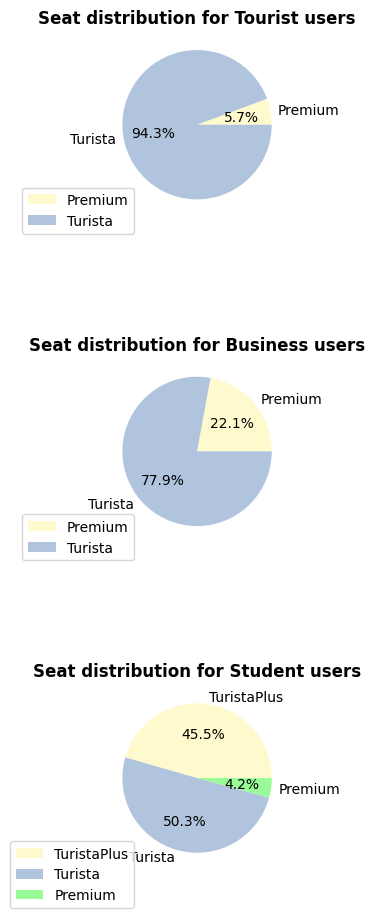

In [27]:
# Simulate market
kernel = Kernel(path_config_supply=supply_config_file,
                path_config_demand=demand_config_path)

services = kernel.simulate(output_path=Path(f'{robin_save_path}output.csv'),
                           save_trace=True,
                           departure_time_hard_restriction=True)

kernel_plotter = KernelPlotter(path_output_csv=Path(f'{robin_save_path}output.csv'),
                               path_config_supply=supply_config_file)

kernel_plotter.plotter_data_analysis()
kernel_plotter.plot_users_seat_pie_chart(save_path='../figures/users_seat_pie_chart.pdf')

In [15]:
!snakeviz profile.pstat

snakeviz web server started on 127.0.0.1:8080; enter Ctrl-C to exit
http://127.0.0.1:8080/snakeviz/%2FUsers%2Fdavid%2FPycharmProjects%2FGSA_M%2Fnotebooks%2Fprofile.pstat
^C

Bye!
